# Comparative Interrupted Time Series: a geo-experimentation example

This notebook demonstrates {term}`Comparative Interrupted Time Series<Comparative interrupted time-series>` (CITS) analysis using a geo-experimentation example. The analysis is based on the approach described in {cite:t}`orduz2022timebased`, which is partially based on {cite:t}`vaver2011measuring`.

## What is Comparative Interrupted Time Series?

**{term}`Comparative Interrupted Time Series<Comparative interrupted time-series>` (CITS)** extends the standard {term}`Interrupted Time Series<Interrupted time series design>` (ITS) design by incorporating control units as predictors in the model. This approach provides stronger causal inference by accounting for common trends and shocks that affect both treated and control units. Crucially, CITS helps guard against a key threat to ITS validity: confounding from unrelated changes that happen to occur at or near the time of intervention. Because control units are subject to the same external events but not the intervention itself, they help disentangle the treatment effect from coincidental changes.

Key characteristics of CITS:
- Uses the `InterruptedTimeSeries` class with control units as predictors
- Formula includes control unit observations: `treated ~ 1 + control_1 + control_2 + ...`
- Can include an intercept (unlike {term}`Synthetic Control`)
- No sum-to-1 constraint on control weights (unlike {term}`Synthetic Control`)
- Provides a middle ground between ITS and Synthetic Control methods
- Additional predictors (like temperature, time of year, or other covariates) can also be included alongside control units

### Comparison: ITS vs CITS vs Synthetic Control

| Aspect | ITS | CITS | Synthetic Control |
|--------|-----|------|-------------------|
| **Control units** | None | Yes, as predictors | Yes, as predictors |
| **Intercept** | Typically yes | Yes | Typically no |
| **Weight constraint** | N/A | None | Sum to 1 |
| **Interpretation** | Counterfactual from time trends | Counterfactual from controls + trends | Weighted combination of controls |
| **Use case** | Single unit, strong trends | Multiple units, common trends | Multiple units, parallel trajectories |

:::{note}
When predictors in the model are **not** control units (e.g., just time, seasonality, or other covariates), you have standard **ITS**. When you include one or more control units as predictors, you have **CITS**.
:::

CITS corresponds to the classic "multiple time-series" design described in the foundational quasi-experimental methods literature {cite:p}`campbell1963experimental`. This design strengthens causal inference when randomization is not possible by using comparison series to control for concurrent events and secular trends.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymc_extras.prior import Prior

import causalpy as cp

/home/runner/.local/lib/python3.12/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## The Geo-Experimentation Scenario

In this example, we analyze a marketing campaign experiment where:
- A company runs an advertising campaign in a subset of geographical regions (treated zipcodes)
- Other regions serve as controls (control zipcodes)
- The outcome of interest is the order rate (orders per customer)
- The campaign runs for a specific time period
- We want to estimate the causal impact of the campaign on order rates

This is a common scenario in digital marketing, retail, and platform businesses where randomization at the user level is not feasible, but geographical or regional-level experiments are possible.

## Load and Prepare Data

The dataset contains synthetic data for 100 zipcodes (33 treatment, 67 control) over 122 days (April 1 - July 31, 2022). A marketing campaign was run in the treatment zipcodes from July 1 to July 31, 2022.

In [3]:
# Load the zipcode data
df_raw = cp.load_data("zipcodes")

# Convert date column to datetime and set as index
df_raw["date"] = pd.to_datetime(df_raw["date"])

# Display basic information
print(f"Date range: {df_raw['date'].min()} to {df_raw['date'].max()}")
print(f"Total zipcodes: {df_raw['zipcode'].nunique()}")
print(
    f"Treatment zipcodes: {df_raw[df_raw['variant'] == 'treatment']['zipcode'].nunique()}"
)
print(
    f"Control zipcodes: {df_raw[df_raw['variant'] == 'control']['zipcode'].nunique()}"
)

df_raw.head()

Date range: 2022-04-01 00:00:00 to 2022-07-31 00:00:00
Total zipcodes: 100
Treatment zipcodes: 33
Control zipcodes: 67


,date,zipcode,is_campaign,is_weekend,is_weekday,norm_trend,population,strength,variant,is_campaign_treatment,order_rate_true_logit,order_rate_true_logit_no_treatment,order_rate_true,order_rate_true_no_treatment,orders,orders_no_treatment,order_rate,order_rate_no_treatment,expected_orders
0,2022-04-01,0,False,False,True,0.000000,3188,1,treatment,False,-1.750000,-1.750000,0.148047,0.148047,500,468,0.156838,0.146801,471.974467
1,2022-04-01,1,False,False,True,0.000082,10054,1,treatment,False,-1.749995,-1.749995,0.148048,0.148048,1521,1505,0.151283,0.149692,1488.472766
2,2022-04-01,2,False,False,True,0.000164,31881,1,treatment,False,-1.749990,-1.749990,0.148048,0.148048,4756,4703,0.149180,0.147517,4719.932276
3,2022-04-01,3,False,False,True,0.000246,2513,1,treatment,False,-1.749985,-1.749985,0.148049,0.148049,364,375,0.144847,0.149224,372.047286
4,2022-04-01,4,False,False,True,0.000328,7559,1,treatment,False,-1.749980,-1.749980,0.148050,0.148050,1121,1096,0.148300,0.144993,1119.107527


### Aggregate Data by Treatment Group

For CITS analysis, we aggregate the data across zipcodes within each group (treatment and control). This gives us:
- One time series for the treated unit (aggregated across all treatment zipcodes)
- One time series for the control unit (aggregated across all control zipcodes)

We'll scale the data by dividing by population to get comparable rates.

In [4]:
# Aggregate by date and variant
df_agg = (
    df_raw.groupby(["date", "variant"])
    .agg({"orders": "sum", "population": "sum"})
    .reset_index()
)

# Calculate scaled order rate (orders per 1000 population)
df_agg["order_rate_scaled"] = (df_agg["orders"] / df_agg["population"]) * 1000

# Pivot to get treatment and control in separate columns
df_pivot = df_agg.pivot(index="date", columns="variant", values="order_rate_scaled")
df_pivot.columns.name = None
df_pivot = df_pivot.reset_index()

# Rename columns for clarity
df_pivot.columns = ["date", "control", "treatment"]

# Set date as index
df_pivot = df_pivot.set_index("date")

print("Aggregated data shape:", df_pivot.shape)
df_pivot.head()

Aggregated data shape: (122, 2)


,control,treatment
date,,
2022-04-01,129.569136,148.440776
2022-04-02,135.286461,154.535738
2022-04-03,135.646855,154.796926
2022-04-04,129.909237,148.492326
2022-04-05,130.229043,148.643540


### Visualise data

Before running the analysis, it's important to check that the treatment and control groups have similar pre-treatment trends. This parallel trends assumption is crucial for causal inference. Control series selection is critical for valid CITS inference; controls should be chosen to avoid contamination and differential shocks while helping address potential co-interventions {cite:p}`lopezbernal2018controls`.

First, let's examine the relationship between treatment and control units during the pre-treatment period. A strong correlation suggests they track each other well, which is desirable for CITS analysis.

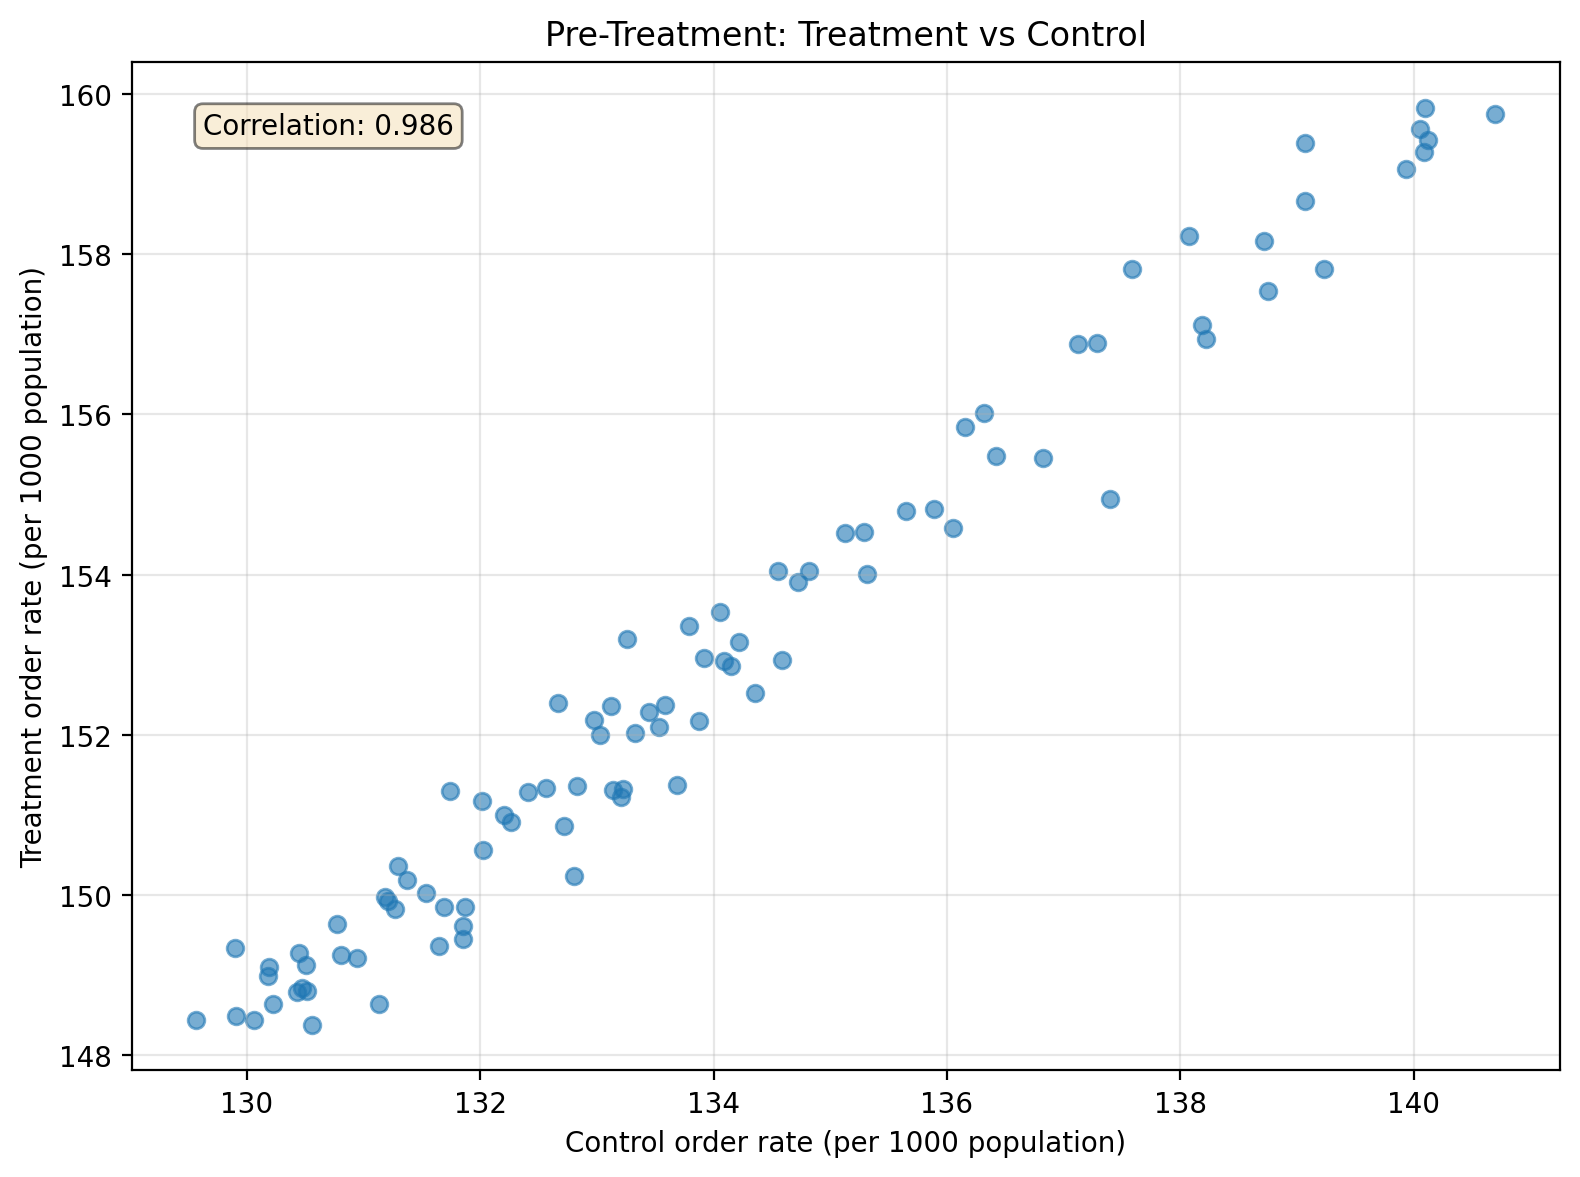

In [5]:
# Define the campaign period for filtering
campaign_start = pd.Timestamp("2022-07-01")

# Pre-treatment scatter plot
pre_treatment = df_pivot[df_pivot.index < campaign_start]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(pre_treatment["control"], pre_treatment["treatment"], alpha=0.6)
ax.set_xlabel("Control order rate (per 1000 population)")
ax.set_ylabel("Treatment order rate (per 1000 population)")
ax.set_title("Pre-Treatment: Treatment vs Control")
ax.grid(True, alpha=0.3)

# Add correlation coefficient
corr = pre_treatment[["control", "treatment"]].corr().iloc[0, 1]
ax.text(
    0.05,
    0.95,
    f"Correlation: {corr:.3f}",
    transform=ax.transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)
plt.tight_layout()
plt.show()

Second, let's plot the full timeseries for both the aggregated treatment and control. Eyeballing it, for the pre-treatment period we can see that the control series is similar to the treatment but with an offset. We can also see a clear increase in the treatment values when the campaign starts.

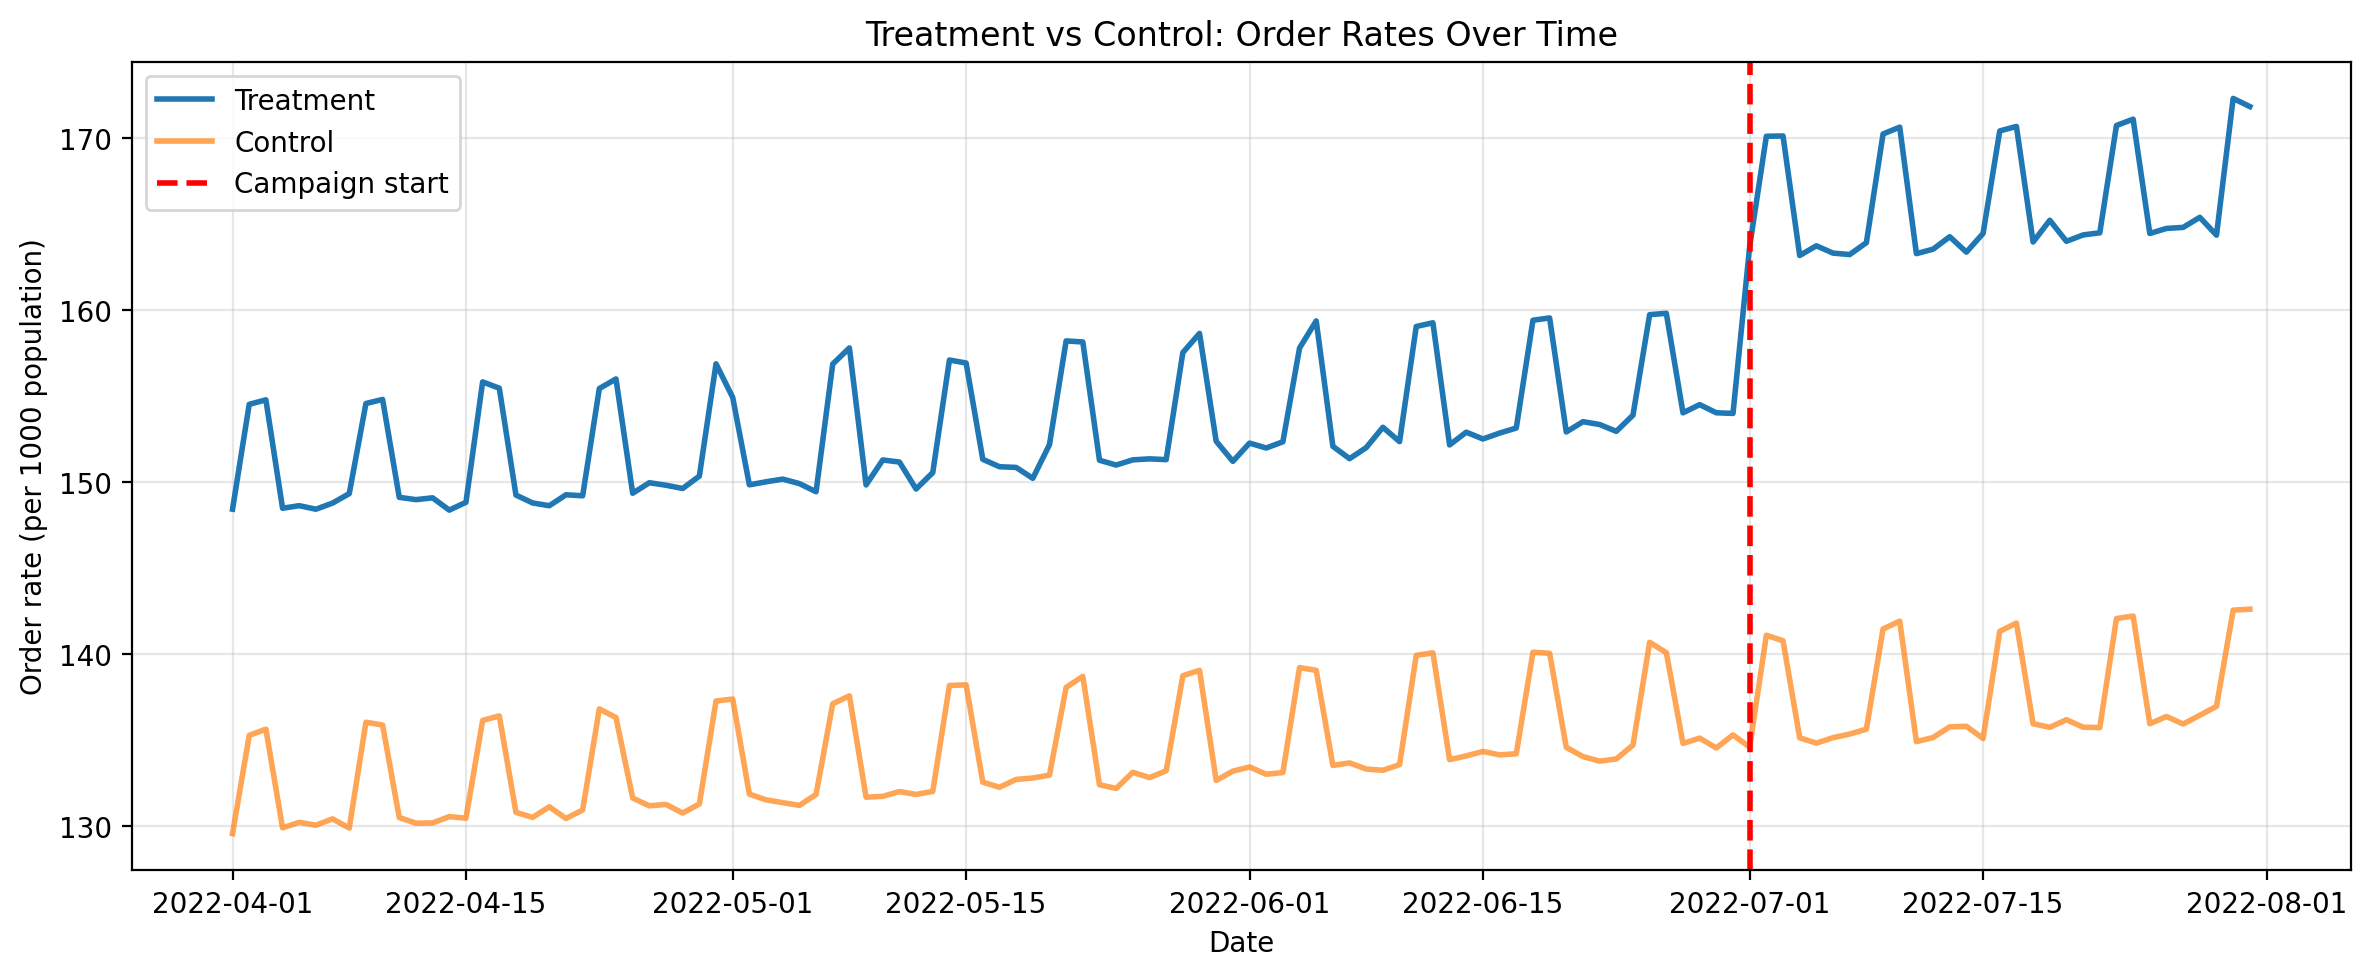

In [6]:
# Plot the time series (campaign_start already defined above)
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_pivot.index, df_pivot["treatment"], label="Treatment", linewidth=2)
ax.plot(df_pivot.index, df_pivot["control"], label="Control", linewidth=2, alpha=0.7)
ax.axvline(
    campaign_start, color="red", linestyle="--", linewidth=2, label="Campaign start"
)
ax.set_xlabel("Date")
ax.set_ylabel("Order rate (per 1000 population)")
ax.set_title("Treatment vs Control: Order Rates Over Time")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## CITS Analysis with the InterruptedTimeSeries Class

Now we use CausalPy's `InterruptedTimeSeries` class to perform CITS analysis. The key difference from standard ITS is that we include the control unit as a predictor in our model formula:

```python
formula = "treatment ~ 1 + control"
```

This formula tells the model:
- Predict `treatment` (the treated unit's order rate)
- Using `control` (the control unit's order rate) as a predictor
- Plus an `intercept` (the `1`)

This formulation aligns with widely-used "multiple-group ITS" practice {cite:p}`linden2015conducting`; CausalPy implements the same design logic within a Bayesian framework.

The model will learn the relationship between treatment and control in the pre-intervention period, then use this to forecast a counterfactual for the post-intervention period.

To more closely follow the approach in {cite:t}`orduz2022timebased`, we override the default Normal likelihood with a Student-T distribution. The heavier tails of the Student-T make the model more robust to outliers, which is often desirable when working with real-world time series data that may contain occasional extreme values.

In [ ]:
result = cp.InterruptedTimeSeries(
    df_pivot,
    treatment_time=campaign_start,
    formula="treatment ~ 1 + control",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "random_seed": seed,
            "progressbar": False,
        },
        priors={
            "y_hat": Prior(
                "StudentT",
                nu=4,
                sigma=Prior("HalfNormal", sigma=1, dims=["treated_units"]),
                dims=["obs_ind", "treated_units"],
            ),
        },
    ),
)

Initializing NUTS using jitter+adapt_diag...


/home/runner/.local/lib/python3.12/site-packages/pytensor/link/c/cmodule.py:2986: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [beta, y_hat_sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 37 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


==================================Pre-Post Fit==================================
Formula: treatment ~ 1 + control
Model coefficients:
    Intercept    6.8, 94% HDI [2.2, 11]
    control      1.1, 94% HDI [1.1, 1.1]
    y_hat_sigma  0.47, 94% HDI [0.39, 0.56]


In [ ]:
result.summary()

### Interpret the Model Coefficients

The model coefficients tell us about the pre-intervention relationship between treatment and control:

- **Intercept**: The baseline difference between treatment and control when control = 0
- **Control coefficient**: How much the treatment unit's order rate changes for each unit change in the control unit's order rate

A coefficient close to 1 would indicate the treatment and control move in lockstep during the pre-period. The coefficient can be greater than 1 (treatment is more sensitive to factors affecting both) or less than 1 (treatment is less sensitive).

## Visualize Results

The plot shows:
1. **Top panel**: Observed data (black dots) vs model predictions
   - Pre-intervention fit (blue)
   - Counterfactual prediction (orange) - what would have happened without the campaign
   - The gap between observed and counterfactual is the causal impact
2. **Middle panel**: The causal impact at each time point
3. **Bottom panel**: The cumulative causal impact over time

/tmp/ipykernel_3475/4224462085.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


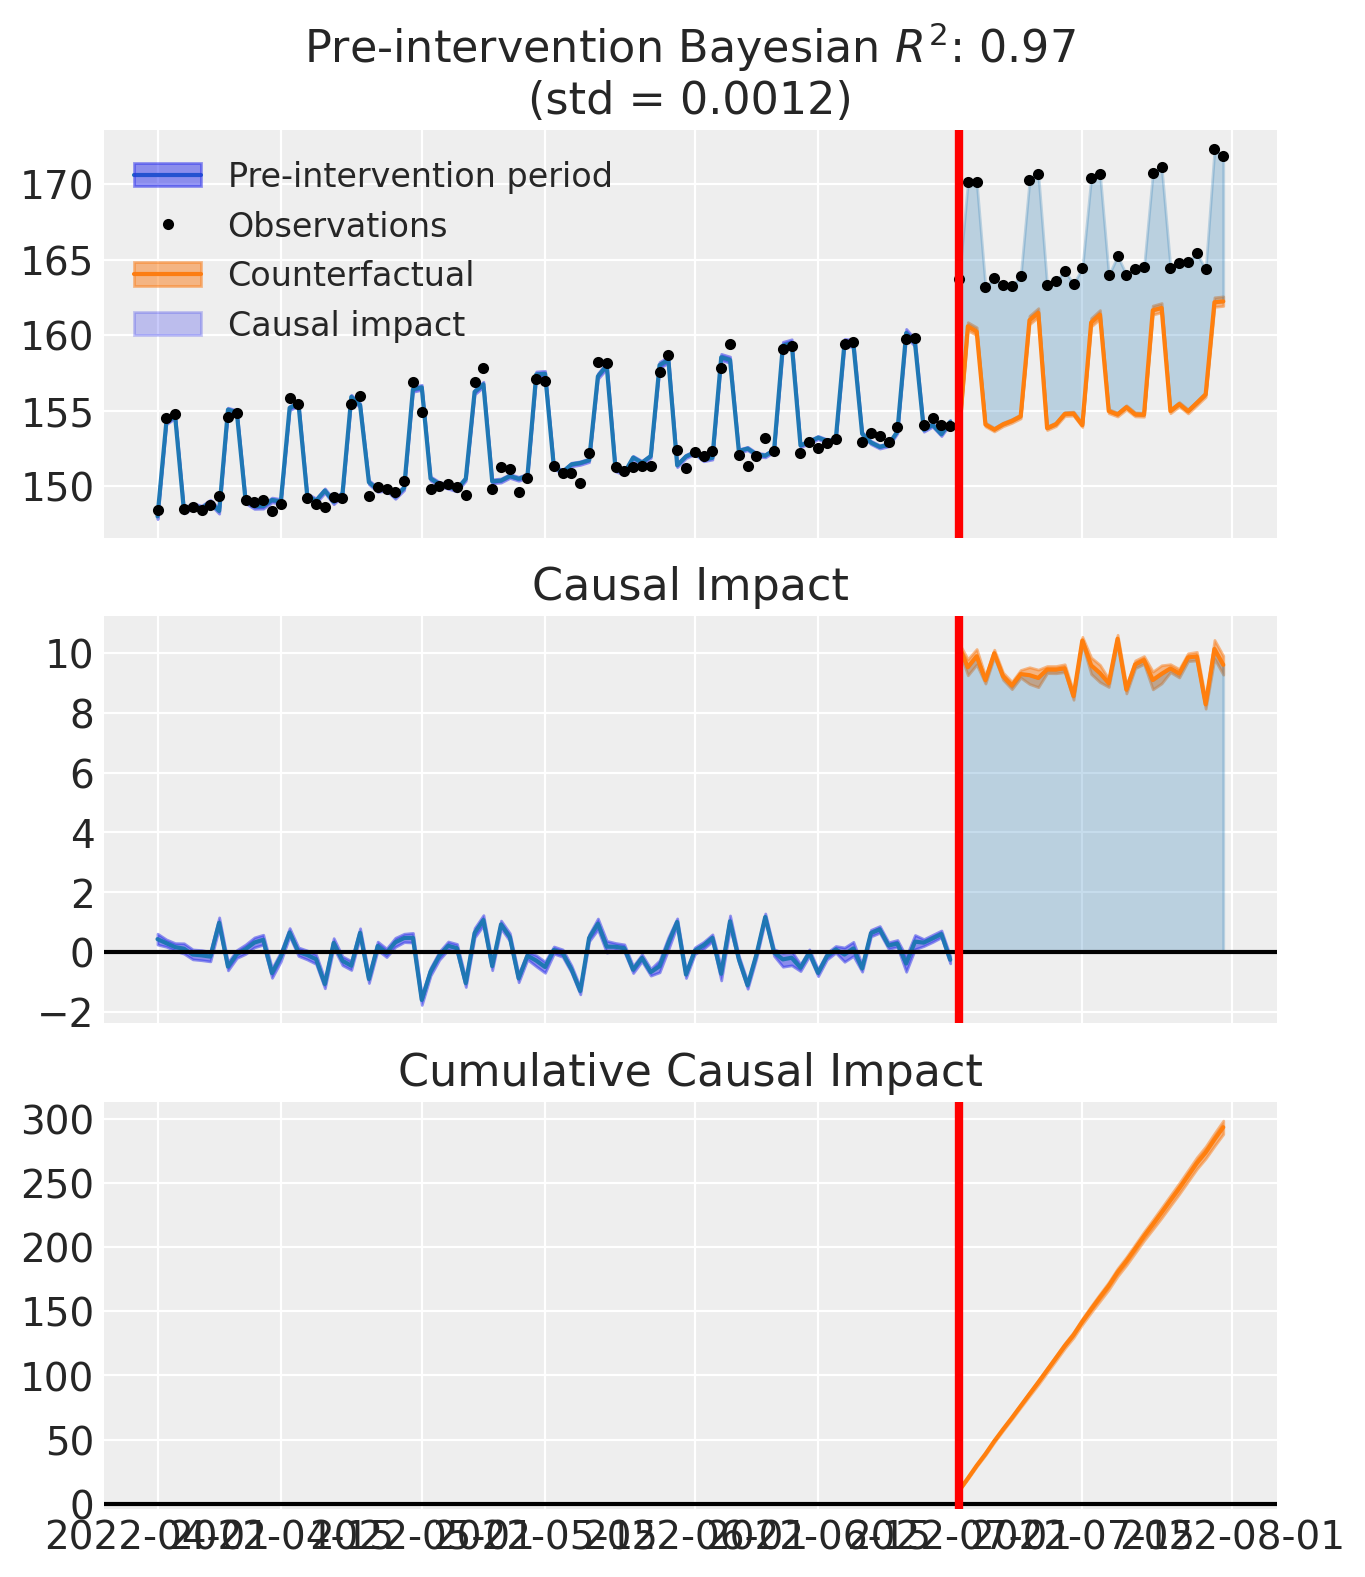

In [ ]:
fig, ax = result.plot()
# plt.tight_layout()
# plt.show()

## Effect Summary

Let's quantify the causal effect of the campaign using the `effect_summary()` method. This provides:
- Average impact per time period
- Cumulative impact over the entire post-intervention period
- Highest Density Intervals (HDIs) for uncertainty quantification
- Tail probabilities for hypothesis testing

In [9]:
summary = result.effect_summary(direction="increase", alpha=0.05)
print(summary.text)
print("\nDetailed statistics:")
summary.table

Post-period (2022-07-01 00:00:00 to 2022-07-31 00:00:00), the average effect was 9.47 (95% HDI [9.31, 9.66]), with a posterior probability of an increase of 1.000. The cumulative effect was 293.62 (95% HDI [288.47, 299.42]); probability of an increase 1.000. Relative to the counterfactual, this equals 6.04% on average (95% HDI [5.93%, 6.17%]).

Detailed statistics:


,mean,median,hdi_lower,hdi_upper,p_gt_0,relative_mean,relative_hdi_lower,relative_hdi_upper
average,9.471656,9.472680,9.305542,9.658582,1.0,6.040548,5.928294,6.167076
cumulative,293.621344,293.653075,288.471810,299.416040,1.0,6.040548,5.928294,6.167076


### Interpretation

The effect summary tells us:
- **Average impact**: The mean difference between observed and counterfactual order rates per day
- **Cumulative impact**: The total additional orders (scaled per 1000 population) attributable to the campaign
- **Credible intervals**: Range of plausible values for the true effect
- **Tail probability**: Probability that the effect is in the direction hypothesized (increase)

These statistics provide evidence for decision-making about the campaign's effectiveness.

## Model Diagnostics

It's important to check that our Bayesian model has converged properly and that the MCMC sampler has explored the posterior distribution effectively.

In [10]:
# Check model diagnostics
# Rhat should be close to 1.0, effective sample size should be large
az.summary(result.model.idata, var_names=["beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[unit_0, Intercept]",6.809,2.452,2.072,11.044,0.076,0.053,1049.0,1252.0,1.0
"beta[unit_0, control]",1.090,0.018,1.057,1.124,0.001,0.000,1047.0,1287.0,1.0


## Key Takeaways

1. **CITS provides robust causal inference** by using control units to account for common trends and external shocks
2. **The `InterruptedTimeSeries` class is flexible** - it can handle standard ITS (no control predictors), CITS (control predictors), and various model specifications
3. **Pre-treatment fit is crucial** - a good model fit in the pre-period gives us confidence in the counterfactual predictions
4. **Uncertainty quantification matters** - Bayesian credible intervals tell us the range of plausible effects, not just a point estimate
5. **CITS sits between ITS and Synthetic Control** - it borrows strength from controls without the strict constraints of Synthetic Control

## Differences Between ITS and CITS

### Why CITS is often preferred when feasible

**1. Control for concurrent events**
- **ITS**: vulnerable if something else changes at the same time (e.g., a new guideline, coding change, economic shift)
- **CITS**: the control series helps account for those shared shocks, improving internal validity

**2. Core identifying assumption**
- **ITS**: assumes that, absent the intervention, the pre-intervention trend would have continued (and no other intervention affects the series at that time)
- **CITS**: assumes that, absent the intervention, the treated and control would have followed similar trajectories (often framed as a "parallel trends" idea, but allowing rich pre-trends and seasonality)

Adding comparison series is a recognized strengthening feature within the ITS family of designs {cite:p}`shadish_cook_cambell_2002`.

**3. Data requirements**
- **ITS**: one series is enough
- **CITS**: needs a credible control series (and must check for spillovers/contamination)

**4. Failure modes**
- CITS can be biased if the control is poorly chosen (different underlying drivers), if the intervention indirectly affects the control (spillover), or if other changes affect treated and control differently

Within-study comparisons have shown that CITS can achieve good validity, but may be biased when comparison unit construction or preprocessing is weak {cite:p}`stclair2016validity`.

## When to Use Which Method

- **Use ITS** when a good control group/series does not exist, but you have many pre- and post-intervention observations and can argue no major coincident changes
- **Use CITS** when you can identify a credible comparison series and want stronger protection against coincident events and secular trends
- **Use Synthetic Control** when you have multiple control units and want to construct an optimal weighted combination, particularly when no single control tracks the treated unit well

For a comprehensive treatment of ITS variants and quasi-experimental design more broadly, see {cite:t}`shadish_cook_cambell_2002`. For practical guidance on selecting and validating control series in public health applications, see {cite:t}`lopezbernal2018controls`.

## References

:::{bibliography}
:filter: docname in docnames
:::